In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from multihist import Hist1d

from flamedisx.x1t_sr0 import SR0NRSource, SR0ERSource

# raise errors on any warning
import warnings
warnings.filterwarnings("error")

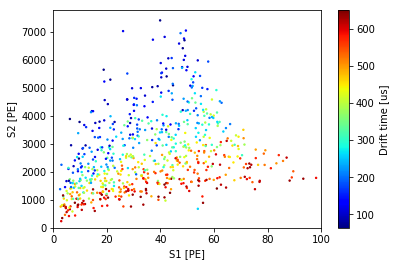

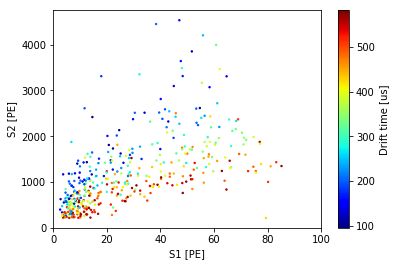

In [2]:
dsets = dict(
    er=dict(source=SR0ERSource,
            data=pd.read_csv('data_Rn220_lowenergy.csv')),
    nr=dict(source=SR0NRSource,
            data=pd.read_csv('data_AmBe_lowenergy.csv')[::8]))


def std_axes():
    plt.xlabel("S1 [PE]")
    plt.ylabel(r"S2 [PE]")
    plt.xlim(0, 100)
    plt.ylim(0, None)

for dname, q in dsets.items():
    d = q['data']
    s = q['source']
    s.annotate_data(d)

    # Cut at CES < 10.
    # a cs1 cut would likely cause a bias since for some energies
    # you'd only have some extreme events.
    d = q['data'] = d[d['e_vis'] < 10].copy()
    
    # Initialize the source
    q['source_class'] = s
    q['source'] = s(d)
    
    plt.scatter(d['s1'], d['s2'], s=2, c=d['drift_time']/1e3, cmap=plt.cm.jet)
    plt.colorbar(label="Drift time [us]")
    std_axes()
    plt.show()

# Compute likelihood

100%|██████████| 67/67 [00:32<00:00,  2.45it/s]


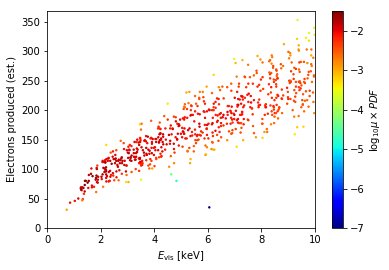

  0%|          | 0/44 [00:00<?, ?it/s]WARNING: Logging before flag parsing goes to stderr.
W0712 16:50:21.063581 140364692145984 deprecation.py:323] From /home/jelle/miniconda3/envs/py37/lib/python3.7/site-packages/tensorflow_probability-0.7.0rc0-py3.7.egg/tensorflow_probability/python/distributions/poisson.py:193: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
100%|██████████| 44/44 [00:10<00:00,  4.22it/s]


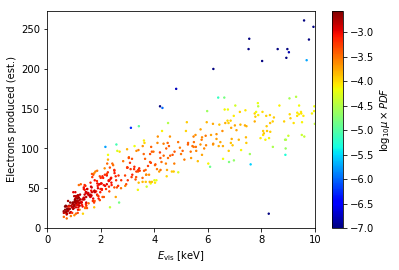

In [3]:
for dname, q in dsets.items():
    d = q['data']
    if 'likelihood' not in d.columns:
        d['likelihood'] = q['source'].batched_differential_rate()

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        d['ll'] = np.log10(d['likelihood'])
        
    plt.scatter(d['e_vis'], 
                d['electron_produced_mle'],
                c=d['ll'], vmin=-7,
                cmap=plt.cm.jet, s=2)
    plt.colorbar(label=r'$\log_{10} \mu \times PDF$')

    plt.xlabel(r"$E_\mathrm{vis}$ [keV]")
    plt.ylabel("Electrons produced (est.)")
    plt.xlim(0, 10)
    plt.ylim(0, None)
    plt.show()

## Compare data with simulation

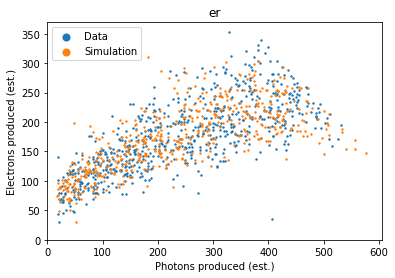

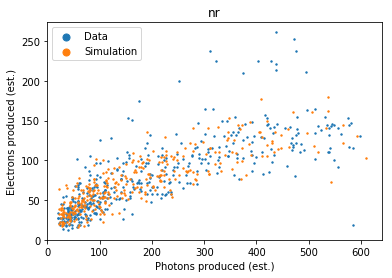

In [5]:
for dname, q in dsets.items():
    s = q['source']
    d = s.simulate(len(q['data']), data=q['data'])
    
    d = d[d['e_vis'] < 10]
    q['data_sim'] = d
    
    for d, label in ([q['data'], 'Data'], [q['data_sim'], 'Simulation']):
        plt.scatter(d['photon_produced_mle'], d['electron_produced_mle'], 
                    label=label, s=2)
        
    plt.xlabel("Photons produced (est.)")
    plt.ylabel("Electrons produced (est.)")
    plt.legend(loc='upper left', markerscale=5)

    plt.title(dname)
    plt.xlim(0, None)
    plt.ylim(0, None)
    plt.show()

The agreement is pretty good. Not perfect -- but that's not the point:
  * For ER, I didn't want to spend hours implementing the fine details of the SR0 ER model (such as the electron lifetime time distribution).
  * For NR, I don't know the AmBe energy spectrum, so I just compare with a high-mass WIMP. The agreement isn't great, but at least the NR band seems to be in approximately the right place, which is OK for now.

Though it's not much of a check (since it doens't involve the likelihood at all), we can also check whether the estimated and actual produced number of photons/electrons match:

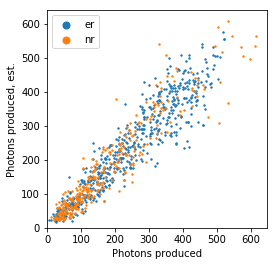

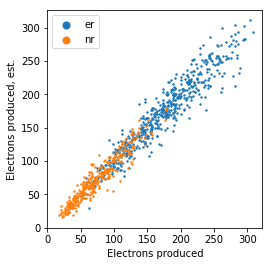

In [6]:
for qt in ['photon', 'electron']:
    for dname, q in dsets.items():
        d = q['data_sim']

        plt.scatter(d[f'{qt}_produced'], d[f'{qt}_produced_mle'], s=2, label=dname)
        plt.xlabel(f"{qt.capitalize()}s produced")
        plt.ylabel(f"{qt.capitalize()}s produced, est.")

    plt.legend(markerscale=5)
    plt.xlim(0, None)
    plt.ylim(0, None)
    plt.gca().set_aspect('equal')
    plt.show()

and whether the min-max bounds are reasonable:

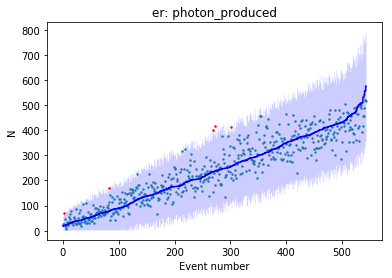

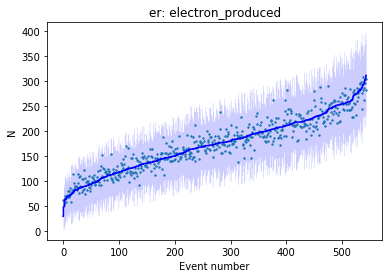

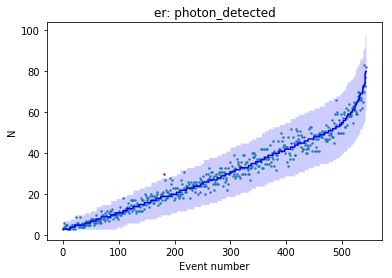

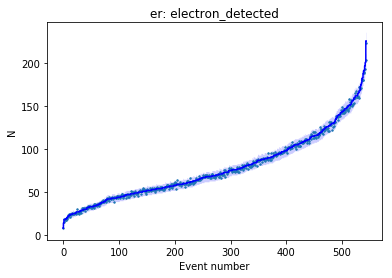

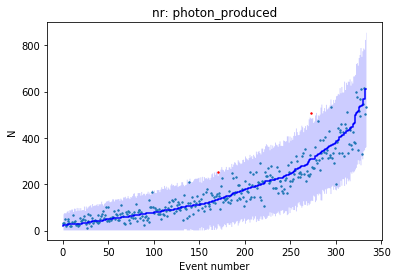

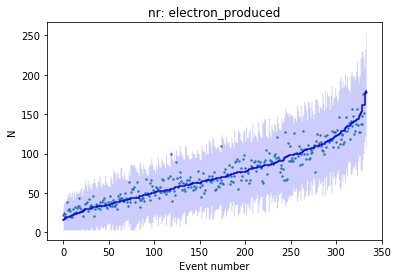

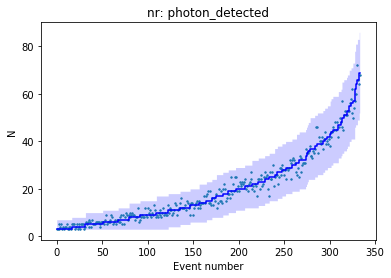

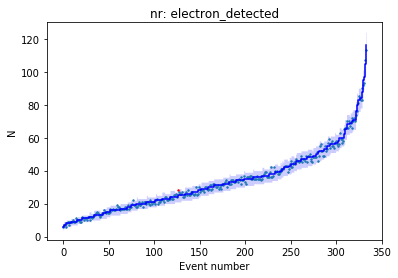

In [7]:
for dname, q in dsets.items():
    for kind in ('produced', 'detected'):
        for qt in ['photon', 'electron']:
            d = q['data_sim'].copy()
            key = qt + '_' + kind
            d = d.sort_values(by=[key + '_mle',
                                  key + '_min'])

            mi, ma, mle, real = d[[key + x 
                                   for x in ('_min', '_max', '_mle', '')]].values.T
            x = np.arange(len(d))
            plt.fill_between(x, ma, mi, 
                             step='mid', color='b', alpha=0.2, linewidth=0)
            plt.plot(x, mle, c='b', linestyle='steps-mid')
            
            fail = (real < mi) | (real > ma)
            plt.scatter(x[fail], real[fail], c='r', s=2)
            plt.scatter(x[~fail], real[~fail], s=2)

            plt.title(dname + ': ' + key)
            plt.xlabel("Event number")
            plt.ylabel("N")
            plt.show()

# Compare with MC likelihood

For this we have to simulate events at *one* position, so the likelihood becomes two-dimensional. Then we can build a histogram using the simulation, and convert it to a PDF estimate.

In [ ]:
import flamedisx
from tqdm import tqdm
from multihist import Histdd

n_trials = int(1e5)
n_batches = 100
evt_i = 0
evt_df = dsets['er']['data'].iloc[evt_i:evt_i+1]

for dname, q in dsets.items():
    # del q['mh']
    if 'mh' in q:
        mh = q['mh']
    else:
        mh = Histdd(bins=(
            np.geomspace(2, 70, 70),
            np.geomspace(200, 6000, 70)))

        for _ in tqdm(range(n_batches)):
            _d = q['source'].simulate(n_trials, data=evt_df)
            mh.add(_d['s1'], _d['s2'])

        # Convert to PDF
        mh /= mh.bin_volumes() * n_trials * n_batches
        
        # Multiply by total expected event rate
        # (from the source, i.e. before correcting for efficiencies)
        mh *= q['source'].energy_spectrum_hist().n
        
        q['mh'] = mh
        
    mh.plot(cblabel=r'$\mu \times \mathrm{PDF}$')
    plt.xlabel("S1 [PE]")
    plt.ylabel("S2 [PE]")
    plt.yscale('log')
    plt.xscale('log')
    plt.show()


In [ ]:
for dname, q in dsets.items():
    # del q['simd']
    if 'simd' in q:
        d = q['simd']
    else:
        d = q['source'].simulate(1000, data=evt_df)
        # Avoid extrapolation in MC likelihood
        d = d[(d['s1'] < 70)]
        d = d[d['s2'] < 6000]
        q['simd'] = d

        # Note the higher max_sigma here to ensure good results
        # TODO: fix bound calcs!
        q['source'].set_data(d, max_sigma=3 if dname == 'er' else 4)
        d['likelihood'] = q['source'].batched_likelihood()
        d['likelihood_2'] = q['mh'].lookup(d['s1'], d['s2'])
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        d['ll_full'] = np.log10(d['likelihood'])
        d['ll_mh'] = np.log10(d['likelihood_2'])

    plt.scatter(
        d['ll_mh'].values,
        d['ll_full'].values,
        c=d['energy'], cmap=plt.cm.jet,
        s=0.5)
    ma, mi = d['ll_mh'].max() + 0.2, d['ll_mh'].min() - 0.2
    plt.plot([mi, ma], [mi, ma], c='k', alpha=0.3, label='Y = X')
    plt.legend(loc='upper left', frameon=False)
    plt.xlim(mi, ma)
    plt.ylim(mi, ma)
    
    plt.colorbar(label='Recoil energy [keV]')
    plt.xlabel("Log10 MC likelihood")
    plt.ylabel("Log10 Full likelihood")
    plt.gca().set_aspect('equal')
    plt.title(dname)
    plt.show()

In [ ]:
for dname, q in dsets.items():
    d = q['simd']
    
    plt.scatter(d['e_vis'], 
                d['electron_produced_mle'],
                c=np.log10(d['likelihood']), vmin=-7,
                cmap=plt.cm.jet, s=2)
    plt.colorbar(label=r'$\log_{10}$ Likelihood')

    plt.xlabel(r"$E_\mathrm{vis}$ [keV]")
    plt.ylabel("Electrons produced (est.)")
    plt.xlim(0, 10)
    plt.ylim(0, None)
    plt.title(dname)
    plt.show()

In [ ]:
for dname, q in dsets.items():
    d = q['simd']

    lmax = d['likelihood'].max()
    f = 1000
    
    (q['mh'] * f).plot(cmap=plt.cm.Greys, vmax=lmax * f, 
                         cblabel='PDF (MC) x %d' % f)
    
    plt.scatter(d['s1'], d['s2'], s=0.5, c=f * d['likelihood'], 
                cmap=plt.cm.jet, vmax=lmax * f)
    plt.colorbar(label='PDF (full) x %d' % f)
    plt.xlabel("S1 [PE]")
    plt.ylim(0, None if dname == 'er' else 3000)
    plt.xlim(0, None if dname == 'er' else 40)
    plt.ylabel("S2 [PE]")
    plt.show()